# Project: Finding Donors for CharityML
## Supervised Learning

## About the project
In this project, I will employ several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. my goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.




## About the Data
The dataset for this project originates from the UCI Machine Learning Repository. The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". You can find the article by Ron Kohavi online. The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

## 1. Import libraries 

In [1]:
## Load the google drive into the co-lab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Import libraries
import numpy as np                  # https://numpy.org/doc/stable/user/whatisnumpy.html
import pandas as pd                 # https://www.activestate.com/resources/quick-reads/what-is-pandas-in-python-everything-you-need-to-know/
import matplotlib.pyplot as plt     # https://www.activestate.com/resources/quick-reads/what-is-matplotlib-in-python-how-to-use-it-for-plotting/
import seaborn as sns               # https://www.analyticsvidhya.com/blog/2019/09/comprehensive-data-visualization-guide-seaborn-python/


Mounted at /content/drive


## Load Data

In [2]:
# The data in csv file, we will load it into the notebook using Pandas
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/census.csv')
data.head(2)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


## 2. Data Exploration

In [3]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print(f"Total number of records: {n_records}")
print(f"Individuals making more than $50,000: {n_greater_50k}")
print(f"Individuals making at most $50,000: {n_at_most_50k}")
print(f"Percentage of individuals making more than $50,000: {greater_percent}%")

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


### Hint 1

*   As we see that our data have 45222 record, and i think it's size is look good for the goal of project

*   The Percentage of individuals making more than $50,000 is 24% so we are dealing with imbalanced data here.


In [4]:
# Look at some informations like Missingness, Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


### Hint 2

*   We have alot of Object datatype so we should encoding them before modeling.
*   The target variable is object also we should encode it to 0 and 1 before modeling.
*   we didn't have missing values in our data, Pretty Nice!

In [5]:
# Look at the unique values in each feature.
def unique():
    unique_values = {}
    for col in data.columns:
        if data[col].dtype == 'object':
            unique_values[col] = pd.unique(data[col].values)
    return unique_values

unique()

{'education_level': array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
        ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
        ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
        ' 12th', ' 1st-4th'], dtype=object),
 'income': array(['<=50K', '>50K'], dtype=object),
 'marital-status': array([' Never-married', ' Married-civ-spouse', ' Divorced',
        ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
        ' Widowed'], dtype=object),
 'native-country': array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
        ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
        ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
        ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
        ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
        ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
        ' Outlying-US(Guam-USVI-etc)', ' Scotland

### Categorical Features

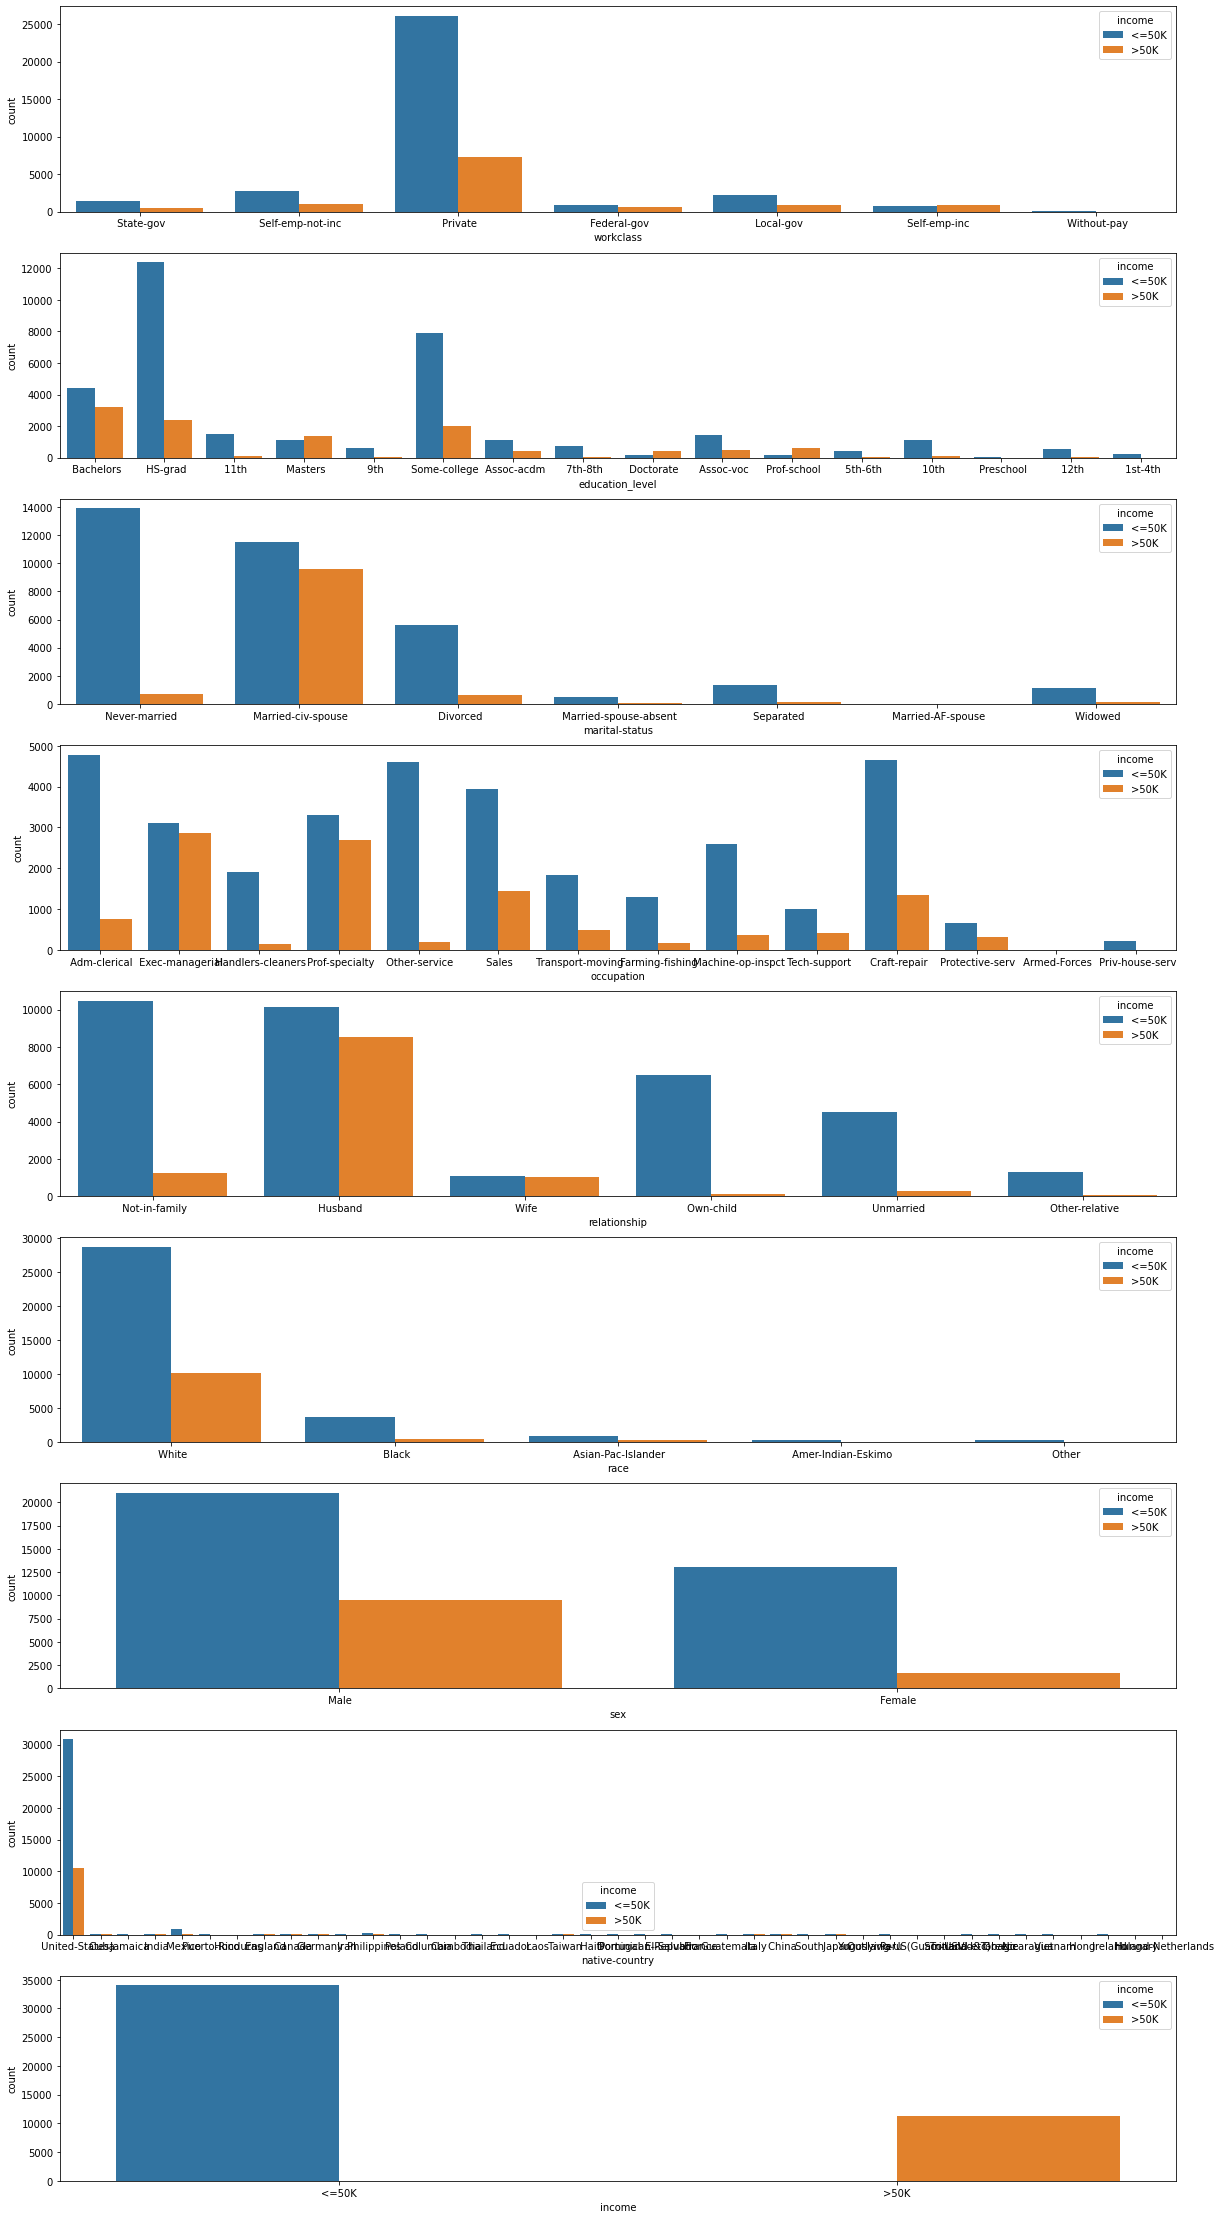

In [6]:
## It's time to take a look to the distribution of the categorical variables.
categ_cols = [col for col in data.columns if data[col].dtype == 'object']
fig, ax = plt.subplots(9, 1, figsize=(20,40))
idx = 0
for i in range(len(categ_cols)):
    sns.countplot(x = categ_cols[idx], data = data, ax = ax[i],hue='income')
    idx+=1
plt.show()

### Customer Story
Although Our data is imbalanced, but we can say that our ideal donor is Someone working at Private Campany or Self-Employed as Exec-Manager or Prof-speciality, type of contract is full-time (based on numerical exploration) Have Hs-Degree or Bacholer Degree, and he or she is married. 

### Numerical features

In [7]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [8]:
data['hours-per-week'].value_counts().head()

40.0    21358
50.0     4094
45.0     2602
60.0     2085
35.0     1776
Name: hours-per-week, dtype: int64

#### **Hint 1**
It seems that Capital-gain and capital-loss have Extreme Values, also on a High Scale.

<Figure size 1440x1440 with 0 Axes>

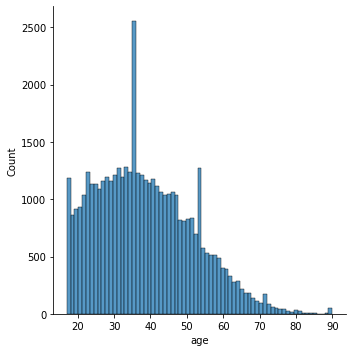

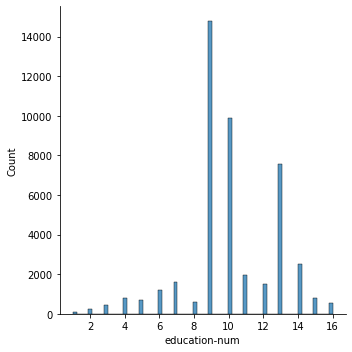

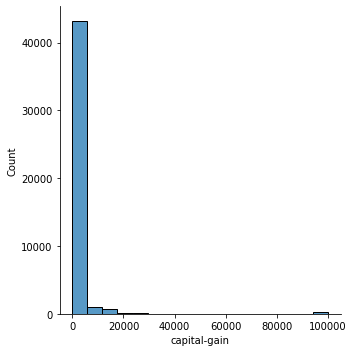

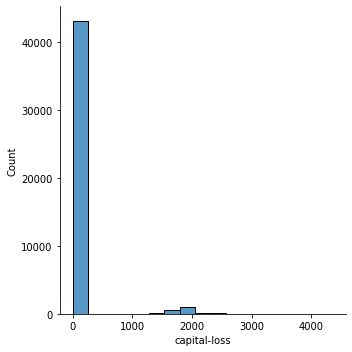

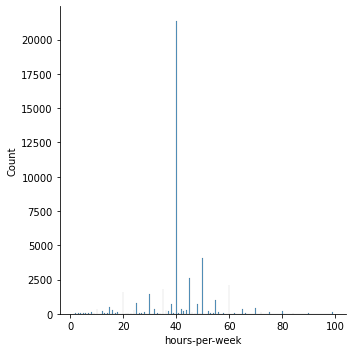

In [9]:
# Look at the distribution of the numerical variables
num_cols = [col for col in data.columns if data[col].dtype != 'object']

plt.figure(figsize=(20,20))
for i in range(len(num_cols)):
    sns.displot(x = num_cols[i], data = data)
plt.show()

#### Hint 2 

Looking at the graph above, all the numerical feature is looks good except capital-gain and capital-loss, affected with Outliers and the values on High Scale, and it will be good if we doing some normalization.

## Data Preparation

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted

Since the algorithms can be sensitive to Skewed distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'

In [10]:
# take a copy from the original data
census = data.copy(deep=True)

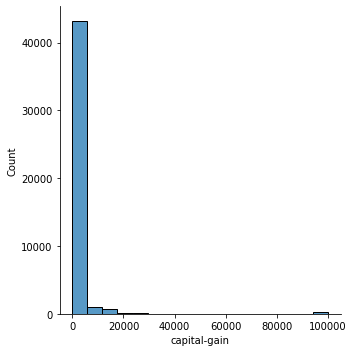

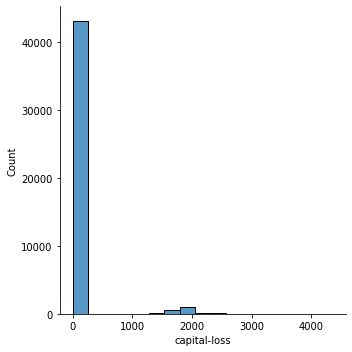

In [11]:
# Visualize skewed continuous features of original data
for col in ['capital-gain', 'capital-loss']:
    sns.displot(x = census[col], data = census)
plt.show()

### Hint 1
For highly-skewed feature distributions such as 'capital-gain' and 'capital-loss', it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers.

In [12]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
census[skewed] = census[skewed].apply(lambda x: np.log(x + 1))

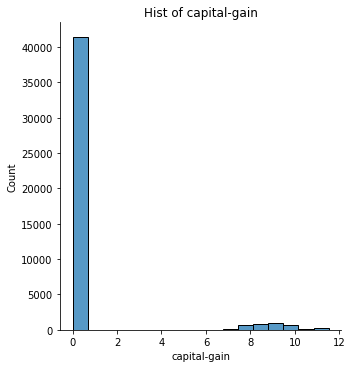

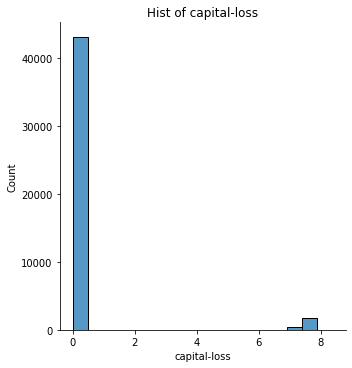

In [13]:
# Visualize after transformation
for col in ['capital-gain', 'capital-loss']:
    sns.displot(x = census[col], data = census)

    plt.title(f'Hist of {col}', fontsize=12)
plt.show()

In [14]:
# Using Min/Max Scalar to Do Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

census[numerical] = scaler.fit_transform(census[numerical])
census.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.607897,0.064342,0.042423,0.407531
std,0.181067,0.170192,0.214240,0.190454,0.122526
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


### **Pre-Processing**

For Modeling Purpose Should divide our data to train and test and we should isloate the Target, then convert all non-numerical features to numerical. So Let's do it 

In [15]:
# iSOLATE TARGET FEATURE FROM THE DATA
X_features = census.drop('income', axis=1)
y_target = census['income']

In [16]:
# Convert Cat variables to dummies using Pandas
X_features = pd.get_dummies(X_features, drop_first = True)

len(X_features.columns)

95

In [17]:
# Convert The INCOME to Binary value ( 0, 1 )
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_target = encoder.fit_transform(y_target)
y_target.shape

(45222,)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=42)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


**Feature** **Selection**

In [19]:
# Information Gain
# from pandas import dataframe
from sklearn.feature_selection import mutual_info_classif
important = mutual_info_classif(X_features, y_target)
feat_important = pd.Series(important, X_features.columns)


In [20]:
feat_important.sort_values(ascending=False)

marital-status_ Married-civ-spouse    0.109187
capital-gain                          0.087057
marital-status_ Never-married         0.064850
education-num                         0.064058
age                                   0.062495
                                        ...   
native-country_ England               0.000000
native-country_ India                 0.000000
native-country_ France                0.000000
native-country_ Germany               0.000000
native-country_ Yugoslavia            0.000000
Length: 95, dtype: float64

**Choose the Performance Measures.**

The target variable is Imblanced so i recommend using the following Measures: 

1- Percision and Recall 

2- F1 Score

3- AUC - ROC 

4- Cross-validation accuracy

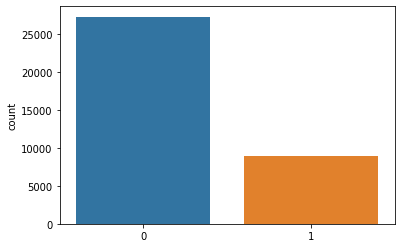

In [21]:
sns.countplot(x=y_train)
plt.show()

In [22]:
# Import Measurs
from sklearn.metrics import accuracy_score, fbeta_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score


## Modeling
In this section, we will investigate Five different algorithms, and determine which is best at modeling the data. these algorithms will be supervised learners.

**The following are the supervised learning models:**

1. Decision Trees
2. Stochastic Gradient Descent Classifier (SGDC)
3. Support Vector Machines (SVM)
4. K-Nearest Neighbors (KNeighbors)
5. Ensemble Methods

### 1. Support Vector Machines (SVC)

**What are the strengths of the model ?**

1- It works really well with a clear margin of separation

2- It is effective in high dimensional spaces.

3- It is effective in cases where the number of dimensions is greater than the number of samples (Cusre of dimensionsality).

4- It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

**What are the weaknesses of the model ?**

1- It doesn’t perform well when we have large data set because the required training time is higher

2- It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping

3- SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

In [23]:
# Import SVC Model
from sklearn.svm import SVC

# initalize
svc_model = SVC(random_state=42)

# Train the model
svc_model.fit(X_train, y_train)

# Make Prediction
svc_pred = svc_model.predict(X_test)


In [24]:
# Accuracy score
svm_accuracy = accuracy_score(y_test, svc_pred)
# fbeta Score
svm_fbeta = fbeta_score(y_test, svc_pred, beta=1)
# Cross_val_accuracy
svm_cross_val = cross_val_score(svc_model, X_test, y_test, cv = 5)


print("Accuracy score on testing data: {:.4f}".format(svm_accuracy))
print("cross val score on testing data: {}".format(np.mean(svm_cross_val)))
print("F-score on testing data: {:.4f}".format(svm_fbeta))


Accuracy score on testing data: 0.8413
cross val score on testing data: 0.838253178551686
F-score on testing data: 0.6449


In [25]:
# Classification Report
svm_report = classification_report(y_test, svc_pred, output_dict=True)

svm_report = pd.DataFrame(svm_report)
svm_report

,0,1,accuracy,macro avg,weighted avg
precision,0.863499,0.748420,0.841349,0.805960,0.834237
recall,0.935063,0.566522,0.841349,0.750792,0.841349
f1-score,0.897857,0.644890,0.841349,0.771374,0.833532
support,6745.000000,2300.000000,0.841349,9045.000000,9045.000000


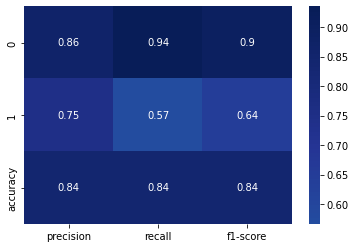

In [26]:
# Visualize Classification report
sns.heatmap(svm_report.iloc[:-1, :3].T, annot=True, center=0, cmap="YlGnBu")
plt.show()

The model have High percision 86% and Low Recall 57%

In [27]:
# # Visualize the percision and recall curve
# from sklearn.metrics import precision_recall_curve
# precisions, recalls, thresholds = precision_recall_curve(y_test, svc_pred)

# def plot_precision_recall(precisions, recalls):
#     sns.lineplot(x=recalls[:-1], y= precisions[:-1])
#     plt.xticks(np.arange(0,1.1,0.1))
#     plt.yticks(np.arange(0,1.1,0.1))
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')

# plot_precision_recall(precisions, recalls)
# plt.show()


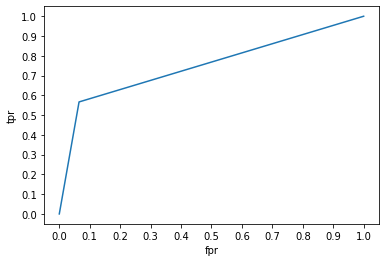

In [28]:
# Visualize the roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc_pred)
def plot_roc_curve(fpr, tpr, label=None):
    sns.lineplot(x=fpr, y= tpr)
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
plot_roc_curve(fpr, tpr)
plt.show()


### Evaluate and choose the best model

In [29]:
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

def train_pred_eval(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, random_state=0):

    # Instantiate
    svm_model = SVC(random_state=random_state)
    sgd_model = SGDClassifier(random_state=random_state)
    knn_model = KNeighborsClassifier()
    decision_model = DecisionTreeClassifier(random_state=random_state)



    learners = [svm_model, sgd_model, knn_model, decision_model]
    cross_score = {}
    fbeta = {}
    train_time = {}

    # Train
    for learner in learners:

        # Learn
        start = time()
        learner.fit(X_train, y_train)
        end = time()

        # Predict
        learner_name = learner.__class__.__name__
        y_pred = learner.predict(X_test)

        # Scores
        train_time[learner_name] = end-start
        fbeta[learner_name] = fbeta_score(y_test, y_pred, beta=0.5)
        cross_score[learner_name] = np.mean(cross_val_score(learner, X_test,y_test))
   
    print(f"train time : {train_time}")
    print(f"Cross Val : {cross_score}")
    print(f"F0.5 Score : {fbeta}")
    

train_pred_eval()

train time : {'SVC': 106.65814685821533, 'SGDClassifier': 0.45618605613708496, 'KNeighborsClassifier': 0.013034820556640625, 'DecisionTreeClassifier': 0.8054039478302002}
Cross Val : {'SVC': 0.838253178551686, 'SGDClassifier': 0.8436705362078497, 'KNeighborsClassifier': 0.8110558319513543, 'DecisionTreeClassifier': 0.8082918739635158}
F0.5 Score : {'SVC': 0.7032599309153713, 'SGDClassifier': 0.711759504862953, 'KNeighborsClassifier': 0.6581325301204819, 'DecisionTreeClassifier': 0.6539823008849557}



**Looking at the results above, Show that SVC perform well on testing data, but it take a lot of time to train, considering both metrics and time I suggest choosing the SGDClassifier model. It runs faster, predicts well enough and more importantly it is simple**

## Feature Selection

In [30]:
# Using Random Forest
from sklearn.ensemble import RandomForestClassifier
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_
feature_importances = pd.DataFrame(model.feature_importances_, index =model.feature_names_in_,  columns=['importance']).sort_values('importance', ascending=False)

top_ten_features = feature_importances[0:10]
top_ten_features

,importance
age,0.240368
hours-per-week,0.115853
capital-gain,0.107676
marital-status_ Married-civ-spouse,0.091896
education-num,0.064642
capital-loss,0.038426
marital-status_ Never-married,0.036294
occupation_ Exec-managerial,0.020426
relationship_ Not-in-family,0.018981
sex_ Male,0.018023


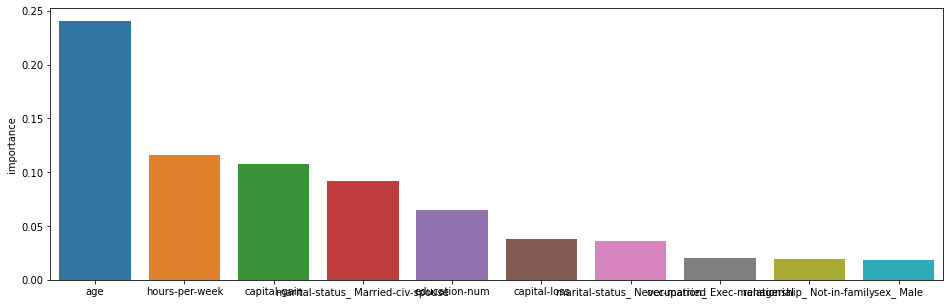

In [31]:
plt.figure(figsize=(16,5))
sns.barplot(data = top_ten_features, x= top_ten_features.index, y=top_ten_features['importance'])
plt.show()

# **In Progress** ✈
